<font size="7">**Control de posición de disco**</font>

### Hipotesis: 

el motor no tiene dinámica

la friccion con el aire es una constnate por la velocidad

la velocidad de giro del motor es proporcional a la tension

el eje se puede modelar como un resorte k*(dif de thetas)

### Encoder:

400 pulsos/revolucion

### Duty:

-1 = -12 V

1 = 12 V

### FFT:
le restamos el valor medio para que no aparezca una frecuencia 0 y que no rompa todo. Por que hacemos fft? para bode -> es en frecuencias

$ mag = \frac{Y sin (wt+\phi)}{U sin (wt+\phi)} = \frac{fft(Y)}{fft(U)}$

# Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.io as io
from scipy.stats import linregress as lr
import seaborn as sn
import pandas as pd
from numpy.fft import fft, fftfreq
from scipy import signal
sn.set_style("whitegrid")
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.edgecolor'] = '#505b63'
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['axes.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['axes.titlesize']=17
mpl.rcParams['figure.titlesize']=20
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams["legend.title_fontsize"]=15

# Bloque motor
## Cargo datos

In [2]:
data = pd.read_csv('GananciaCorregida.dat', index_col=False, delimiter='\t')
data_2 = pd.read_csv('GananciaCorregida2.dat', index_col=False, delimiter='\t')

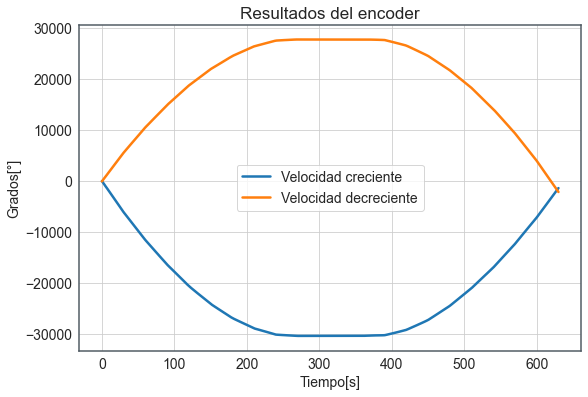

In [3]:
aux = data['pulsos'].to_numpy()
aux_2 = data_2['pulsos'].to_numpy()
for i in range(len(aux)):
    if aux[i]>10000:
        aux[i]-=2*32768
    if aux_2[i]<-10000:
        aux_2[i]+=2*32768    
data['pulsos']=aux
data_2['pulsos']=aux_2
fig = plt.figure(figsize=(9,6))
plt.plot(data['tiempo'], data['pulsos'].to_numpy()*360/400, label='Velocidad creciente')
plt.plot(data_2['tiempo'], data_2['pulsos'].to_numpy()*360/400, label='Velocidad decreciente')
plt.xlabel('Tiempo[s]')
plt.ylabel('Grados[°]')
plt.title('Resultados del encoder')
plt.legend()
plt.savefig('pulsos_vs_tiempo.pdf', format='pdf')
plt.show()

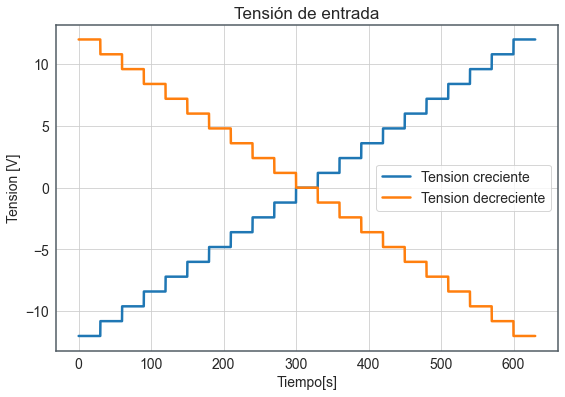

In [4]:
fig = plt.figure(figsize=(9,6))
plt.plot(data['tiempo'], data['duty'].to_numpy()*12, label='Tension creciente')
plt.plot(data_2['tiempo'], data_2['duty'].to_numpy()*12, label='Tension decreciente')
plt.xlabel('Tiempo[s]')
plt.ylabel('Tension [V]')
plt.title('Tensión de entrada')
plt.legend()
plt.savefig('duty_vs_tiempo.pdf', format='pdf')
plt.show()

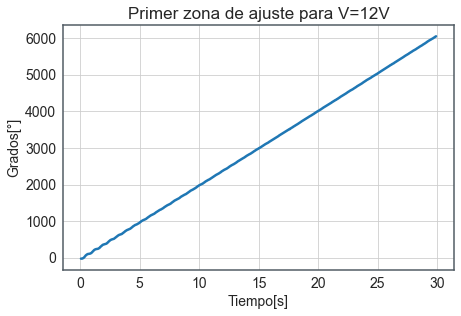

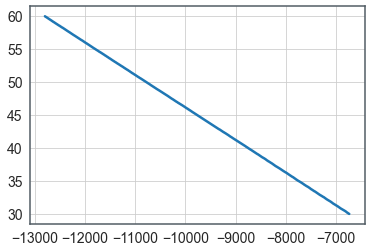

In [5]:
n_dutys=21
n_range=int(len(aux)/n_dutys)
fig = plt.figure(figsize=(7,4.5))
plt.plot( data['tiempo'].to_numpy()[0:n_range], -(data['pulsos'].to_numpy()[0:n_range]*360/400))
plt.ylabel('Grados[°]')
plt.xlabel('Tiempo[s]')
plt.title('Primer zona de ajuste para V=12V')
plt.savefig('zonaajuste.pdf', format='pdf')
plt.show()
plt.plot(data['pulsos'].to_numpy()[n_range:2*n_range], data['tiempo'].to_numpy()[n_range:2*n_range])
plt.show()

D:\Anaconda3\envs\tesis\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt
D:\Anaconda3\envs\tesis\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
D:\Anaconda3\envs\tesis\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda3\envs\tesis\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


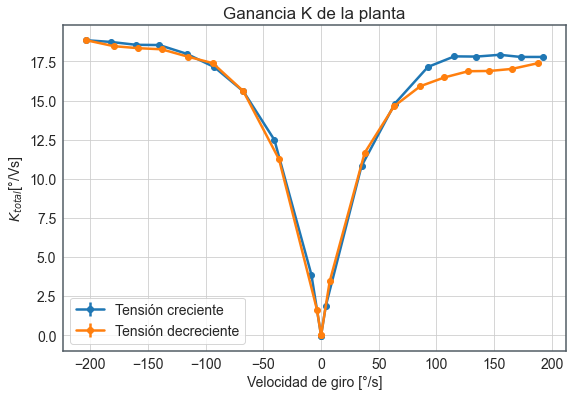

In [6]:
n_dutys=21
n_range=int(len(aux)/n_dutys)
pulsos=[]
tiempos=[]
velocidades=[]
tensiones=[]
err=[]

pulsos_2=[]
tiempos_2=[]
velocidades_2=[]
tensiones_2=[]
err_2=[]
for i in range(n_dutys):
    pulsos.append(data['pulsos'].to_numpy()[i*n_range:(i+1)*n_range])
    tiempos.append(data['tiempo'].to_numpy()[i*n_range:(i+1)*n_range])
    p, cov = np.polyfit(tiempos[i], pulsos[i], deg=1, cov=True)
    cov = np.sqrt(cov)
    velocidades.append(p[0])
    tensiones.append(data['duty'].to_numpy()[i*n_range:i*n_range+1]*12)
    err.append(cov[0,0])
    
    pulsos_2.append(data_2['pulsos'].to_numpy()[i*n_range:(i+1)*n_range])
    tiempos_2.append(data_2['tiempo'].to_numpy()[i*n_range:(i+1)*n_range])
    p_2, cov_2 = np.polyfit(tiempos_2[i], pulsos_2[i], deg=1, cov=True)
    cov_2 = np.sqrt(cov_2)
    velocidades_2.append(p_2[0])
    tensiones_2.append(data_2['duty'].to_numpy()[i*n_range:i*n_range+1]*12)
    err_2.append(cov_2[0,0])
    
velocidades=np.array(velocidades).reshape(-1)
tensiones=np.array(tensiones).reshape(-1)
kms=np.delete((velocidades/tensiones), int(n_dutys/2))

velocidades_2=np.array(velocidades_2).reshape(-1)
tensiones_2=np.array(tensiones_2).reshape(-1)
kms_2=np.delete((velocidades_2/tensiones_2), int(n_dutys/2))

fig = plt.figure(figsize=(9,6))
plt.errorbar(np.delete(velocidades*360/400, int(n_dutys/2)), kms, np.delete(err, int(n_dutys/2)), marker='o', label='Tensión creciente')
plt.errorbar(np.delete(velocidades_2*360/400, int(n_dutys/2)), kms_2, np.delete(err_2, int(n_dutys/2)), marker='o', label='Tensión decreciente')
plt.xlabel('Velocidad de giro [°/s]')
plt.ylabel(r'$K_{total}$[°/Vs]')
plt.title('Ganancia K de la planta')
plt.legend()
plt.savefig('k_planta.pdf', format='pdf')
plt.show()

In [7]:
np.max(kms)/200

0.0942638776994023

In [8]:
np.max(kms/1.1311)

16.667647016073253

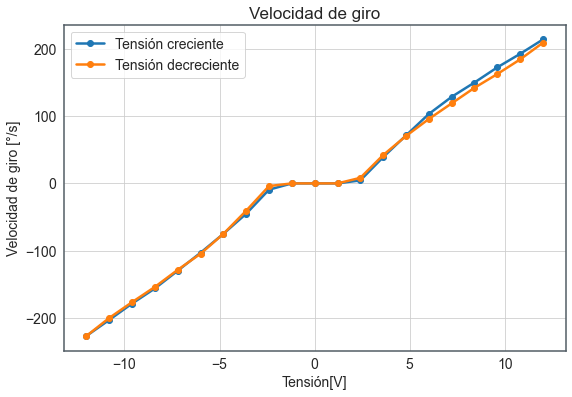

In [9]:
fig = plt.figure(figsize=(9,6))
plt.plot(tensiones, velocidades, marker='o', label='Tensión creciente')
plt.plot(tensiones_2, velocidades_2, marker='o', label='Tensión decreciente')
plt.xlabel('Tensión[V]')
plt.ylabel('Velocidad de giro [°/s]')
plt.title('Velocidad de giro')
plt.legend()
plt.savefig('pulsos_vs_tesion.pdf', format='pdf')
plt.show()

# Caracterización del disco

In [10]:
chirp = pd.read_csv('chirp.dat', index_col=False, delimiter='\t')

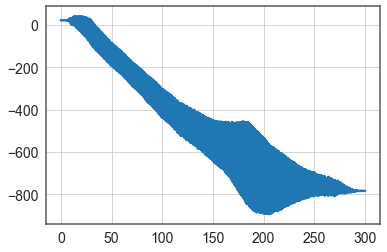

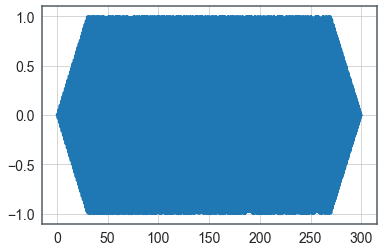

In [11]:
plt.plot(chirp['tiempo'], chirp['pulsos'])
plt.show()
plt.plot(chirp['tiempo'], chirp['tension'])
plt.show()

In [12]:
def shift_bit_length(x):
    return 1<<(x-1).bit_length()

def smooth(a,WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))

T=np.max(chirp['tiempo'].to_numpy())
N=shift_bit_length(len(chirp['tiempo'].to_numpy()))

velocidad=np.diff(chirp['pulsos'].to_numpy())/np.diff(chirp['tiempo'].to_numpy())
velocidad= -smooth(velocidad, 5)
tension=chirp['tension'].to_numpy()
pulsos=chirp['pulsos'].to_numpy()

fft_velocidad = fft(velocidad, N)/N#-np.mean(velocidad))
fft_tension = fft(tension, N)/N#-np.mean(tension))
fft_G = fft_velocidad/fft_tension
freq = fftfreq(N, d=T/N)



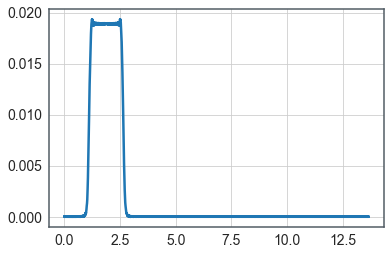

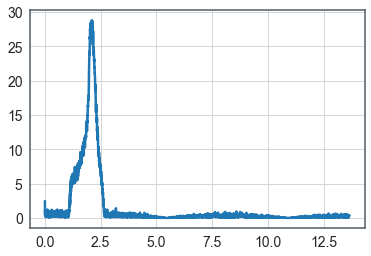

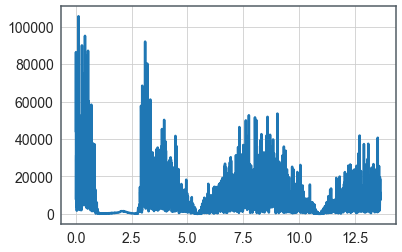

In [13]:
plt.plot(freq[:int(N/2)], np.abs(fft_tension[:int(N/2)]))
plt.show()
plt.plot(freq[:int(N/2)], np.abs(fft_velocidad[:int(N/2)]))
plt.show()
plt.plot(freq[:int(N/2)], np.abs(fft_G[:int(N/2)]))
plt.savefig('asd.pdf', format='pdf')
plt.show()

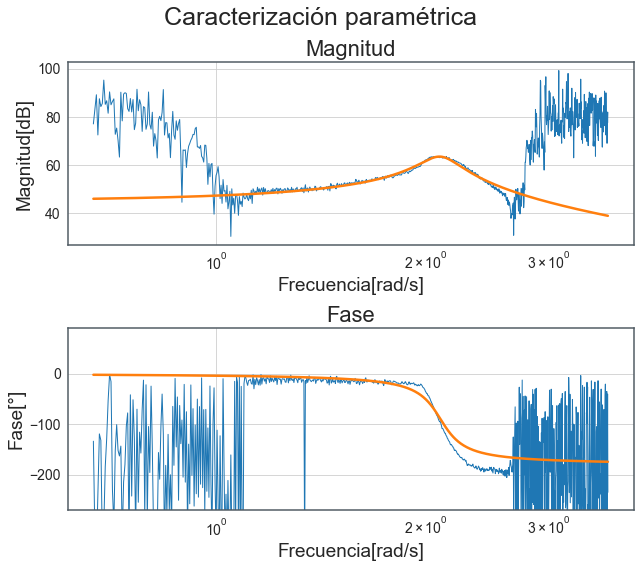

In [30]:
psi = 0.06
wn = 2.1
k = 180

s1 = signal.lti([k*wn**2], [1, 2*psi*wn, wn**2])
w, mag, phase = signal.bode(s1, freq)

fig = plt.figure(figsize=(9,8))
ax1 = plt.subplot(211)
ax1.semilogx(freq[200:int(N/2)-3000], 20*np.log10(np.abs(fft_G)[200:int(N/2)-3000]), linewidth=1)
ax1.semilogx(freq[200:int(N/2)-3000], mag[200:int(N/2)-3000])
ax1.set_xlabel('Frecuencia[rad/s]', fontsize=19)
ax1.set_ylabel('Magnitud[dB]', fontsize=19)
ax1.set_title('Magnitud', fontsize=22)
ax2 = plt.subplot(212)
ax2.semilogx(freq[200:int(N/2)-3000], np.rad2deg(np.angle(fft_G)[200:int(N/2)-3000])-180, linewidth=1)
ax2.semilogx(freq[200:int(N/2)-3000], phase[200:int(N/2)-3000])
ax2.set_ylim([-270, 90])
ax2.set_xlabel('Frecuencia[rad/s]', fontsize=19)
ax2.set_ylabel('Fase[°]', fontsize=19)
ax2.set_title('Fase', fontsize=22)
plt.suptitle('Caracterización paramétrica', fontsize=25)
plt.tight_layout()
plt.savefig('bode.pdf', format='pdf')
plt.show()

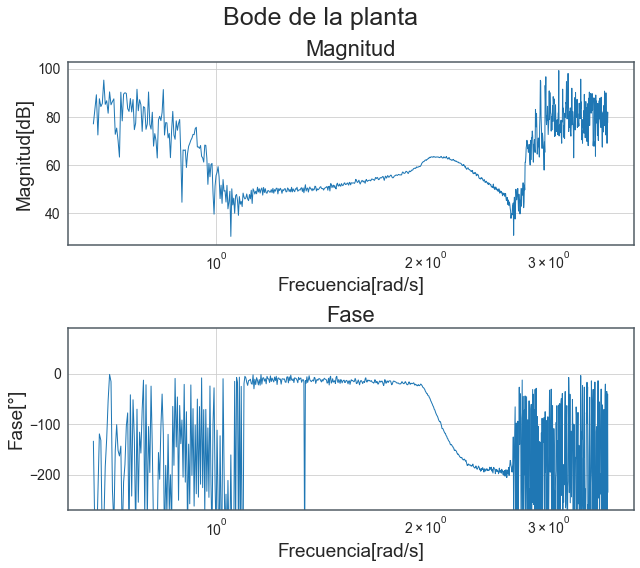

In [31]:
psi = 0.06
wn = 2.1
k = 180

s1 = signal.lti([k*wn**2], [1, 2*psi*wn, wn**2])
w, mag, phase = signal.bode(s1, freq)

fig = plt.figure(figsize=(9,8))
ax1 = plt.subplot(211)
ax1.semilogx(freq[200:int(N/2)-3000], 20*np.log10(np.abs(fft_G)[200:int(N/2)-3000]), linewidth=1)
#ax1.semilogx(freq[200:int(N/2)-3000], mag[200:int(N/2)-3000])
ax1.set_xlabel('Frecuencia[rad/s]', fontsize=19)
ax1.set_ylabel('Magnitud[dB]', fontsize=19)
ax1.set_title('Magnitud', fontsize=22)
ax2 = plt.subplot(212)
ax2.semilogx(freq[200:int(N/2)-3000], np.rad2deg(np.angle(fft_G)[200:int(N/2)-3000])-180, linewidth=1)
#ax2.semilogx(freq[200:int(N/2)-3000], phase[200:int(N/2)-3000])
ax2.set_ylim([-270, 90])
ax2.set_xlabel('Frecuencia[rad/s]', fontsize=19)
ax2.set_ylabel('Fase[°]', fontsize=19)
ax2.set_title('Fase', fontsize=22)
plt.suptitle('Bode de la planta', fontsize=25)
plt.tight_layout()
plt.savefig('bode_s_carac.pdf', format='pdf')
plt.show()

## Parametros reales

In [ ]:
wn=9.5
xi=0.05
rho=2700
d=0.15
e=5/1000
I=np.pi*rho*e*d**4/32

In [ ]:
k_eje = wn**2*I
gamma = 2*xi*wn*I
print(k_eje)
print(gamma)